In [5]:
from scipy.io import loadmat
from netCDF4 import Dataset
import numpy as np
import gsw



In [48]:
import scipy.sparse

#Units of "per year" for the transport matrix
base_transport = loadmat("OCIM2_48L_base_transport.mat")
#filter out the 'exit flux'
pos_base_tr_mat = base_transport['TR'].multiply(base_transport['TR'] > 0)
#normalize to get fractional contributions. Row is dest, col is source
transition_prob_mat = scipy.sparse.diags(1.0/np.asarray(np.sum(pos_base_tr_mat, axis=1)).flatten()) @ pos_base_tr_mat

In [6]:
data = Dataset("OCIM2_48L_base_data.nc")
tridx_to_fullgrid_idxs = np.nonzero(data.variables['ocnmask'][:].data)

In [8]:
list(data.variables.keys())

['ocnmask',
 'tlat',
 'tlon',
 'tz',
 'ulat',
 'ulon',
 'wz',
 'vol',
 'area',
 'kappa_para',
 'kappa_perp',
 'ptemp',
 'salt',
 'Delta14C',
 'del3He',
 'year_cfc11',
 'year_cfc12',
 'cfc11',
 'cfc12',
 'heatflux',
 'saltflux',
 'mld',
 'uvel',
 'vvel',
 'wvel',
 'ssh',
 'mantle_3he_flux']

In [25]:
ocnmask = data.variables['ocnmask'][:].data==1.0
ulat = data.variables['ulon'][:].data #latlon are swapped in file
ulon = data.variables['ulat'][:].data #latlon are swapped in file
wz = data.variables['wz'][:].data
salt = data.variables['salt'][:].data #units of psu means 'practical' sal?
ptemp = data.variables['ptemp'][:].data #ptempt wrt surface?
ssh = data.variables['ssh'][:].data #reference pressure? assuming ~0 dbar

In [191]:
ulat_ocnvec = ulat.ravel()[ocnmask.ravel()]
ulon_ocnvec = ulon.ravel()[ocnmask.ravel()]
#convert ulon to have negative longitudes
ulon_ocnvec = ulon_ocnvec*(ulon_ocnvec <= 180) + (-(360-ulon_ocnvec)*(ulon_ocnvec > 180))

depth_ocnvec = wz.ravel()[ocnmask.ravel()]

#z is expected to be negative in the ocean
#gives pressure in dbar
#removing geo_strf_dyn_height still gives stuff
# that's pretty correlated
p_ocnvec = gsw.p_from_z(
    z=-depth_ocnvec,
    lat=ulat_ocnvec,
    geo_strf_dyn_height=np.tile(ssh[None,:,:], (48,1,1)).ravel()[ocnmask.ravel()])

#absolute salinity
absal_ocnvec = gsw.SA_from_SP(
    SP=salt.ravel()[ocnmask.ravel()],
    p=p_ocnvec,
    lon=ulon_ocnvec,
    lat=ulat_ocnvec)

ctemp_ocnvec = gsw.CT_from_pt(
    SA=absal_ocnvec,
    pt=ptemp.ravel()[ocnmask.ravel()]) #assumes 0 dbar for pt

sig0_ocnvec = gsw.sigma0(SA=absal_ocnvec,CT=ctemp_ocnvec)
sig2_ocnvec = gsw.sigma2(SA=absal_ocnvec,CT=ctemp_ocnvec)
sig4_ocnvec = gsw.sigma4(SA=absal_ocnvec,CT=ctemp_ocnvec)


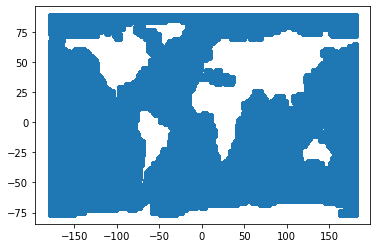

In [192]:
plt.scatter(ulon_ocnvec, ulat_ocnvec)

In [193]:
#copying filter conditions from
# https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/8aba68bf38940ffa7bc84afd7cedc5ac4380ecd2/GP15_Defining_Watermass_Subtypes.ipynb#scrollTo=h5hNQdcE2tnn

def get_nonzero_idxs(lat_min, lat_max,
                     lon_min, lon_max,
                     sig0_min=0, sig0_max=np.inf, 
                     sig2_min=0, sig2_max=np.inf,
                     sig4_min=0, sig4_max=np.inf):
    
    #need to subtract 180 cos ulon_ocnvec goes from 0 to 360
    nonzero_idxs = np.nonzero(
        (ulat_ocnvec >= lat_min)*(ulat_ocnvec <= lat_max)
       *((ulon_ocnvec) >= lon_min)*((ulon_ocnvec) <= lon_max)
       *(sig0_ocnvec >= sig0_min)*(sig0_ocnvec <= sig0_max)
       *(sig2_ocnvec >= sig2_min)*(sig2_ocnvec <= sig2_max)
       *(sig4_ocnvec >= sig4_min)*(sig4_ocnvec <= sig4_max)
    )[0]
    
    return nonzero_idxs

filter_conditions = {
    "AAIW": {"lat_min":-55.0, "lat_max":-43.0,
             "lon_min":-90, "lon_max":-80,
             "sig0_min":27.05, "sig0_max":27.15},
    "NPIW": {"lat_min":34.0, "lat_max":37.0, 
             "lon_min":140.0, "lon_max":153.0, 
             "sig0_min":26.5, "sig0_max":27.4, 
             #"ox_min":0, "ox_max":150.0, #TODO: think about this
             },
    "UCDW": {"lat_min":-49.5, "lat_max":-44.5, 
             "lon_min":-157.0, "lon_max":-147.0,
             "sig0_min":27.35, "sig0_max":27.75,
             },
    "LCDW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "sig0_min":27.79, "sig0_max":27.83,
             },
    "AABW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "sig4_min":46.04, "sig4_max":200,
             },
    "PDW": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig4_min":0, "sig4_max":45.88,
            },
    "EqIW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.86, "sig0_max": 27.3,
             },
    "PSUW": {"lat_min":50, "lat_max":58, 
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "ENPCW": {"lat_min":16, "lat_max":26, 
              "lon_min":-170, "lon_max":-140,
              "sig0_min": 25.29, "sig0_max": 26.86,
              },
    "ESSW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "SPCW": {"lat_min":-30, "lat_max":-20, 
             "lon_min":-152, "lon_max":-130, 
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "SPSTSW": {"lat_min":-20, "lat_max":-15, 
               "lon_min":-152, "lon_max":-142, 
               "sig0_min": 25.29, "sig0_max": 26.86,
              }
}

endmem_to_nonzeroidxs = dict([(the_key, set(get_nonzero_idxs(**val)))
                              for the_key,val in filter_conditions.items()])

AABW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 12.903469583125965
convergence max: 0.00028265885504341615
1000
convergence sum: 5.669940764541427
convergence max: 0.00016770325248322004
2000
convergence sum: 2.8076477928034405
convergence max: 0.00013228132053277886
3000
convergence sum: 1.5216440402538574
convergence max: 0.00010517992928260611
4000
convergence sum: 0.9310782018456131
convergence max: 8.856447378657872e-05
5000
convergence sum: 0.6546947658725665
convergence max: 7.554913190949142e-05
6000
convergence sum: 0.5213519715044431
convergence max: 6.157648411542205e-05
7000
convergence sum: 0.4539507579749829
convergence max: 5.393880119941574e-05
8000
convergence sum: 0.4175641522959849
convergence max: 4.876105795925678e-05
9000
convergence sum: 0.3962106443984579
convergence max: 4.381687246490795e-05
10000


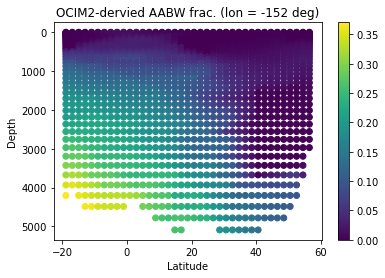

AAIW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 1.1000737257922353
convergence max: 0.00022877294873080434
1000
convergence sum: 0.49258203601483813
convergence max: 9.878195846768634e-05
2000
convergence sum: 0.3255811387865282
convergence max: 6.685824470653579e-05
3000
convergence sum: 0.2508188114070031
convergence max: 4.7491384556452854e-05
4000
convergence sum: 0.21123873666938978
convergence max: 3.522291495383634e-05
5000
convergence sum: 0.18796978156986713
convergence max: 2.909264225386954e-05
6000
convergence sum: 0.17294880642820754
convergence max: 2.526327261770378e-05
7000
convergence sum: 0.16240752148721996
convergence max: 2.210918275560858e-05
8000
convergence sum: 0.15449017998560702
convergence max: 1.9986137755084732e-05
9000
convergence sum: 0.14823431286235417
convergence max: 1.8927839623122944e-05
10000


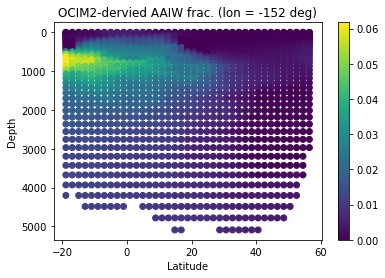

ENPCW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.4883320462169086
convergence max: 4.582979998123127e-05
1000
convergence sum: 0.22365282913021947
convergence max: 2.4683444932553644e-05
2000
convergence sum: 0.168201268140033
convergence max: 1.749954841225032e-05
3000
convergence sum: 0.14756044147581296
convergence max: 1.3061962434876562e-05
4000
convergence sum: 0.13607470080169168
convergence max: 1.1281089868184213e-05
5000
convergence sum: 0.12861190358311927
convergence max: 9.525270127583307e-06
6000
convergence sum: 0.12344028792947116
convergence max: 8.409409782757227e-06
7000
convergence sum: 0.11967630054579398
convergence max: 7.609669788515017e-06
8000
convergence sum: 0.116804731893098
convergence max: 6.977084813952761e-06
9000
convergence sum: 0.11451076242987145
convergence max: 6.57697157368381e-06
10000


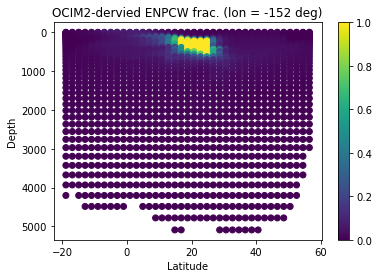

ESSW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.40040585648312366
convergence max: 0.0005500775142310288
1000
convergence sum: 0.28559558756220066
convergence max: 0.0003212857670520375
2000
convergence sum: 0.24649969096949126
convergence max: 0.0002222335746268067
3000
convergence sum: 0.2291423733622843
convergence max: 0.00017695021454311455
4000
convergence sum: 0.21690601912693347
convergence max: 0.0001483403153383911
5000
convergence sum: 0.2056895802059247
convergence max: 0.00012692138966674538
6000
convergence sum: 0.1947660726041868
convergence max: 0.00011020900549629786
7000
convergence sum: 0.18416465805942514
convergence max: 9.794333325985338e-05
8000
convergence sum: 0.17401093859016545
convergence max: 8.636893214908348e-05
9000
convergence sum: 0.1643953429983542
convergence max: 7.484854993844436e-05
10000


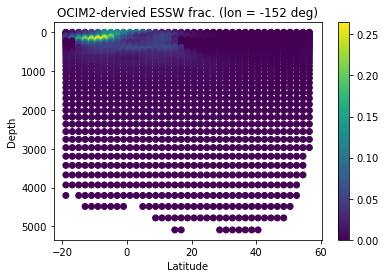

EqIW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 1.4306125618455858
convergence max: 3.692708624904173e-05
1000
convergence sum: 0.4139397533391561
convergence max: 8.699948829791679e-06
2000
convergence sum: 0.17721263818383823
convergence max: 5.706924302623442e-06
3000
convergence sum: 0.09371579239252349
convergence max: 4.39379925910692e-06
4000
convergence sum: 0.058589691478992574
convergence max: 3.7880873217464167e-06
5000
convergence sum: 0.04256856012075357
convergence max: 3.370727219974279e-06
6000
convergence sum: 0.034786367144615964
convergence max: 3.032848720978948e-06
7000
convergence sum: 0.030717121143527773
convergence max: 2.7399957316931456e-06
8000
convergence sum: 0.028387794959106774
convergence max: 2.517705511642654e-06
9000
convergence sum: 0.02691524130887718
convergence max: 2.272148010937919e-06
10000


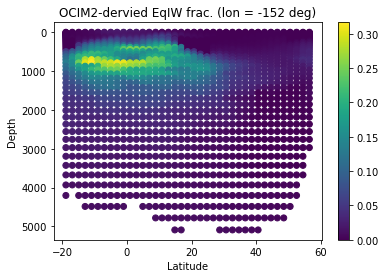

LCDW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 7.379481494008324
convergence max: 0.00014894781351765252
1000
convergence sum: 2.9761188592849814
convergence max: 7.653825728642927e-05
2000
convergence sum: 1.5471938729362518
convergence max: 6.0443982752761416e-05
3000
convergence sum: 0.9232872664336749
convergence max: 4.844040284696094e-05
4000
convergence sum: 0.6339681781331256
convergence max: 3.890405613854453e-05
5000
convergence sum: 0.4954757330632893
convergence max: 3.1266583703504214e-05
6000
convergence sum: 0.4264904996102858
convergence max: 2.51572683661605e-05
7000
convergence sum: 0.39012423906179866
convergence max: 2.302054890901406e-05
8000
convergence sum: 0.36945243654784676
convergence max: 2.1318561211847165e-05
9000
convergence sum: 0.35661288835082766
convergence max: 1.9790509508954557e-05
10000


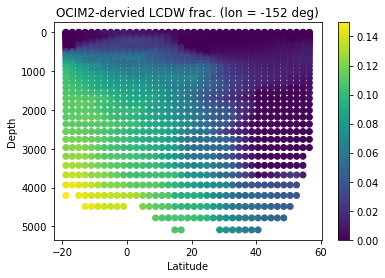

NPIW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 1.313991938027371
convergence max: 0.00019742061217398188
1000
convergence sum: 0.5794627276857593
convergence max: 8.200954832826568e-05
2000
convergence sum: 0.4039708021847
convergence max: 6.33773192519338e-05
3000
convergence sum: 0.34059131375475193
convergence max: 5.515532865968398e-05
4000
convergence sum: 0.3131841979043976
convergence max: 4.715457695220193e-05
5000
convergence sum: 0.298261825239299
convergence max: 4.149007546411232e-05
6000
convergence sum: 0.2875654134435035
convergence max: 3.850122223331143e-05
7000
convergence sum: 0.27809125381205657
convergence max: 3.6454035524546846e-05
8000
convergence sum: 0.26872874721639217
convergence max: 3.4459505905665155e-05
9000
convergence sum: 0.25907663929868346
convergence max: 3.255960439224603e-05
10000


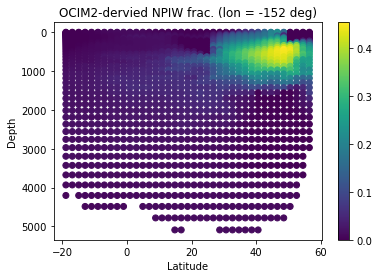

PDW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 7.398846453762492
convergence max: 0.00020199226681621996
1000
convergence sum: 3.259609637466771
convergence max: 9.451468152044118e-05
2000
convergence sum: 1.436769751764519
convergence max: 3.8751498608990964e-05
3000
convergence sum: 0.6575073207148276
convergence max: 1.5785874135976208e-05
4000
convergence sum: 0.32481605984605366
convergence max: 1.1967560629128071e-05
5000
convergence sum: 0.18068047063111664
convergence max: 1.1086520546460532e-05
6000
convergence sum: 0.11679440402838648
convergence max: 1.0645510346289633e-05
7000
convergence sum: 0.08750050721647626
convergence max: 9.891960136010347e-06
8000
convergence sum: 0.07335185989022137
convergence max: 9.011109702458664e-06
9000
convergence sum: 0.0659680592484232
convergence max: 8.12506464553664e-06
10000


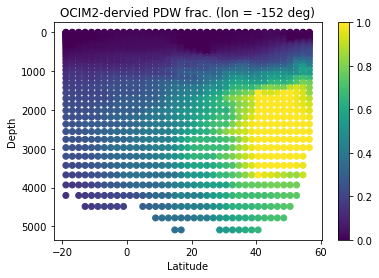

PSUW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.23295812750449807
convergence max: 0.0003093735664480013
1000
convergence sum: 0.1608720742515763
convergence max: 0.00017277323220910024
2000
convergence sum: 0.14019125153558964
convergence max: 0.00011880946689790672
3000
convergence sum: 0.12960093070500173
convergence max: 8.937997253982699e-05
4000
convergence sum: 0.12287474736205856
convergence max: 6.836774561230774e-05
5000
convergence sum: 0.1177391867983203
convergence max: 6.11433987394161e-05
6000
convergence sum: 0.11321976326234115
convergence max: 5.4250439617709034e-05
7000
convergence sum: 0.10895216750335028
convergence max: 4.9522522150791115e-05
8000
convergence sum: 0.1048500204492853
convergence max: 4.525752507950065e-05
9000
convergence sum: 0.10093089976328773
convergence max: 4.206369500342477e-05
10000


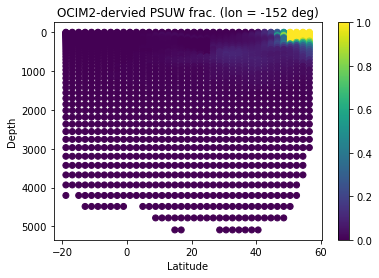

SPCW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.7055909946220507
convergence max: 7.545211760098813e-05
1000
convergence sum: 0.27792733606426123
convergence max: 4.6382470323208524e-05
2000
convergence sum: 0.1777179796747977
convergence max: 3.4014424454373304e-05
3000
convergence sum: 0.1403984434045368
convergence max: 2.930741576681606e-05
4000
convergence sum: 0.12350669604115877
convergence max: 2.6622393181685577e-05
5000
convergence sum: 0.11522922605704675
convergence max: 2.4767702441891304e-05
6000
convergence sum: 0.11098876978945332
convergence max: 2.328354713068692e-05
7000
convergence sum: 0.10873913431890642
convergence max: 2.2177653986932278e-05
8000
convergence sum: 0.10751540875709202
convergence max: 2.1166874772160504e-05
9000
convergence sum: 0.10684921338787122
convergence max: 2.004331123409142e-05
10000


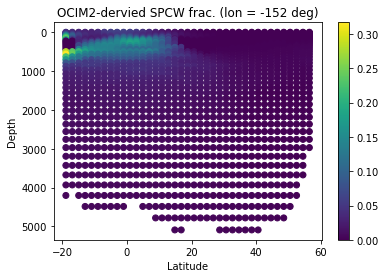

SPSTSW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.21331751863234816
convergence max: 2.5288674556707413e-05
1000
convergence sum: 0.09370650290000879
convergence max: 1.4819864144310912e-05
2000
convergence sum: 0.06580594046759956
convergence max: 1.22082020980116e-05
3000
convergence sum: 0.055315633798829936
convergence max: 1.0328675927810671e-05
4000
convergence sum: 0.05000632624302447
convergence max: 8.965795666601717e-06
5000
convergence sum: 0.04693944714826263
convergence max: 7.972328769062509e-06
6000
convergence sum: 0.04502622598184115
convergence max: 7.1196635440945455e-06
7000
convergence sum: 0.04374890744711164
convergence max: 6.29708975349863e-06
8000
convergence sum: 0.04283838579215133
convergence max: 5.748194339148804e-06
9000
convergence sum: 0.042149686503686515
convergence max: 5.20750544508175e-06
10000


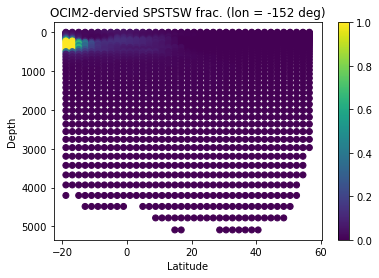

UCDW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 2.7835307828552804
convergence max: 5.126249071112782e-05
1000
convergence sum: 1.0876289532209586
convergence max: 2.16368995634153e-05
2000
convergence sum: 0.4864176178338612
convergence max: 1.0138017200241045e-05
3000
convergence sum: 0.2379503877587811
convergence max: 4.413568802846823e-06
4000
convergence sum: 0.13002161670887838
convergence max: 1.9067545057038782e-06
5000
convergence sum: 0.08183264265067672
convergence max: 1.6175559596764977e-06
6000
convergence sum: 0.0597213487169564
convergence max: 1.4557344430871089e-06
7000
convergence sum: 0.04920174807270987
convergence max: 1.3003107339707581e-06
8000
convergence sum: 0.043933582194584236
convergence max: 1.1552120362749024e-06
9000
convergence sum: 0.04110411316140379
convergence max: 1.0835272475084867e-06
10000


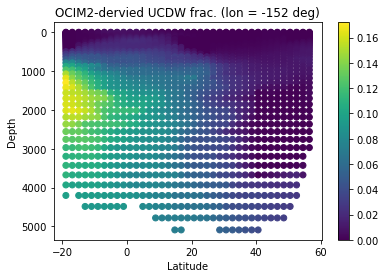

In [224]:
import scipy.sparse
from collections import OrderedDict

class GetSteadyStateFracs(object):
    
    def __init__(self, base_transition_prob_mat, endmem_to_nonzeroidxs, main_endmem):
        
        rows_to_zeroout = np.ones(base_transition_prob_mat.shape[0])
        print("zero out len:",len(rows_to_zeroout))
        for nonzeroidxs in endmem_to_nonzeroidxs.values():
            for idx in nonzeroidxs:
                rows_to_zeroout[idx] = 0.0
        rowzerod_trprobmat = scipy.sparse.diags(rows_to_zeroout) @ base_transition_prob_mat
        
        print("multiplied")
        self.endmem_to_trmatandinitvec = OrderedDict()
        self.endmem_to_lateststatevec = OrderedDict()
        
        print("starting init")
        self.trmat, self.initvec = self.get_trmat_and_initvec_for_endmem(
                            rowzerod_trprobmat=rowzerod_trprobmat,
                            endmem_nonzeroidxs=endmem_to_nonzeroidxs[main_endmem])
        print("ending init")
        self.lateststatevec = self.initvec
        self.total_timesteps = 0
        self.diff_from_prev = None
        
    @staticmethod
    def get_trmat_and_initvec_for_endmem(rowzerod_trprobmat, endmem_nonzeroidxs):
        print("starting copy")
        new_rowzerod_trprobmat = rowzerod_trprobmat.tolil()
        print("finished copy")
        init_label_vec = np.zeros(rowzerod_trprobmat.shape[0])
        for idx in endmem_nonzeroidxs:
            new_rowzerod_trprobmat[idx,idx] = 1.0
            init_label_vec[idx] = 1.0
        return new_rowzerod_trprobmat.tocsc(), init_label_vec
    
    def take_step(self, num_timesteps=1):
        for i in range(num_timesteps):
            oldvec = self.lateststatevec
            self.lateststatevec = (self.trmat @ self.lateststatevec)
            self.diff_from_prev = self.lateststatevec - oldvec
            self.total_timesteps += 1
        print("convergence sum:",np.sum(np.abs(self.diff_from_prev)))
        print("convergence max:",np.max(np.abs(self.diff_from_prev)))
        
endmem = 'NPIW'
    
endmem_to_lateststatevec = OrderedDict()
for endmem in sorted(endmem_to_nonzeroidxs.keys()):
    #endmem='NPIW'
    print(endmem)
    ss_fracs = GetSteadyStateFracs(base_transition_prob_mat=transition_prob_mat,
                                   endmem_to_nonzeroidxs=endmem_to_nonzeroidxs,
                                   main_endmem=endmem)

    for i in range(10):
        ss_fracs.take_step(num_timesteps=1000)
        print(ss_fracs.total_timesteps)

    endmem_to_lateststatevec[endmem] = ss_fracs.lateststatevec
        
    #get the cells corresponding to the gp15 cruise
    gp15_idxs = get_nonzero_idxs(lon_min=-152, lon_max=-152, lat_min=-20, lat_max=60)

    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=ss_fracs.lateststatevec[gp15_idxs],
        #vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title("OCIM2-dervied "+endmem+" frac. (lon = -152 deg)")
    plt.colorbar()
    plt.show()

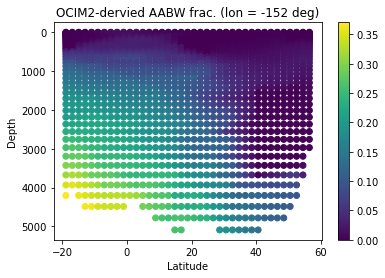

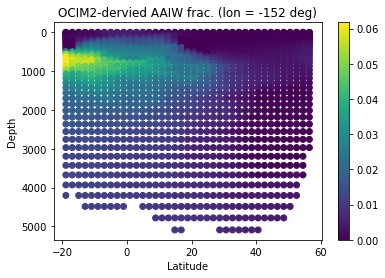

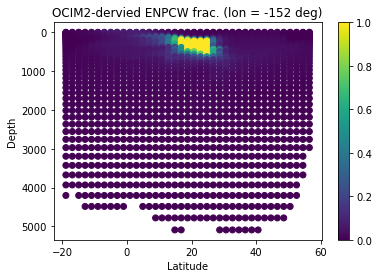

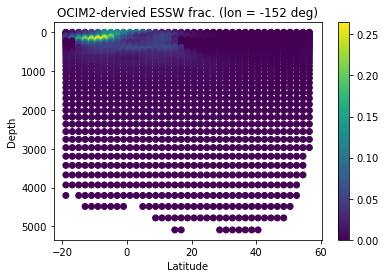

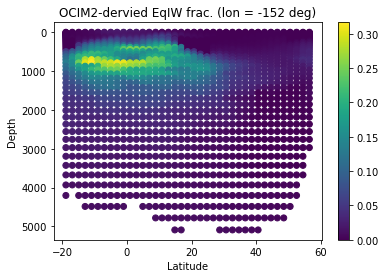

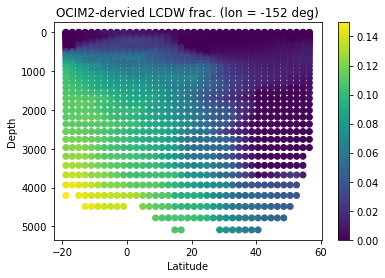

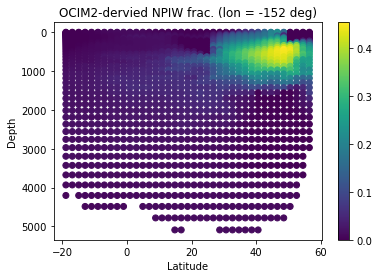

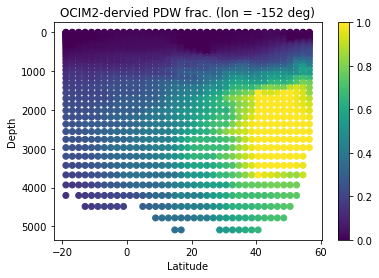

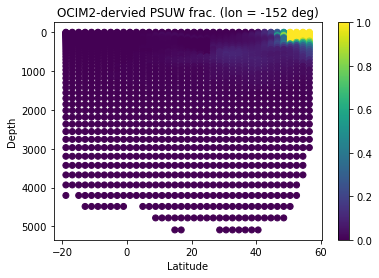

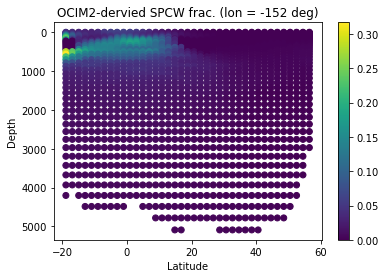

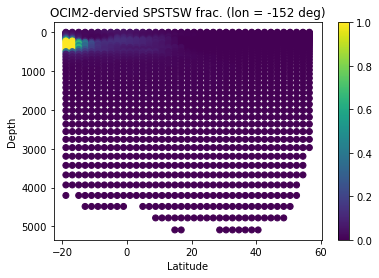

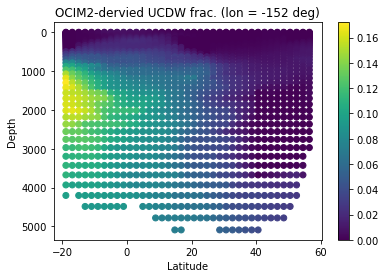

In [226]:
for endmem in endmem_to_lateststatevec:
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=endmem_to_lateststatevec[endmem][gp15_idxs],
        #vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title("OCIM2-dervied "+endmem+" frac. (lon = -152 deg)")
    plt.colorbar()
    plt.show()

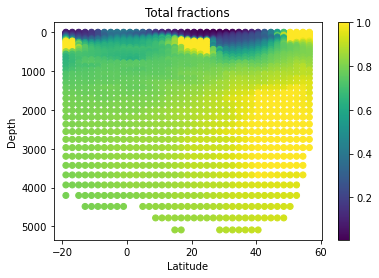

In [229]:
plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=(np.sum(np.array(list(endmem_to_lateststatevec.values())), axis=0))[gp15_idxs],
        #vmin=0.0, vmax=1.0
    )
plt.ylim(plt.ylim()[1], plt.ylim()[0])
plt.ylabel("Depth")
plt.xlabel("Latitude")
plt.title("Total fractions")
plt.colorbar()
plt.show()

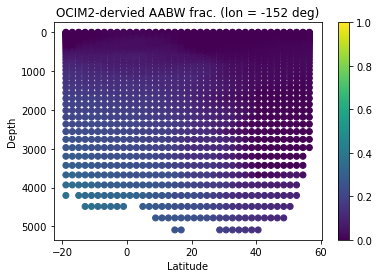

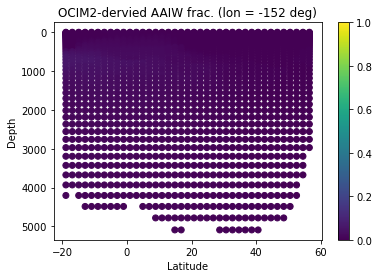

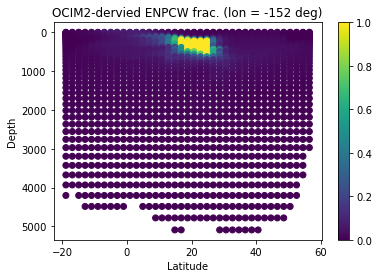

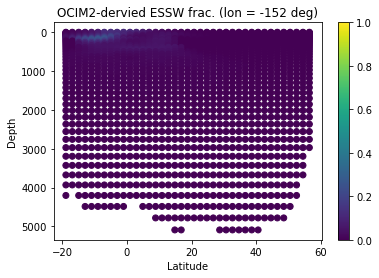

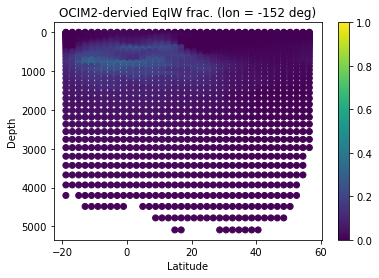

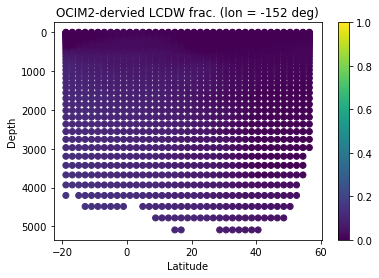

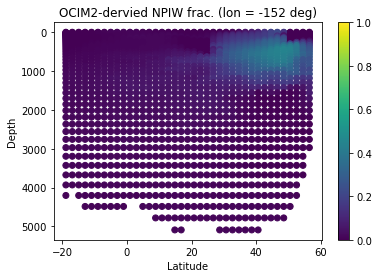

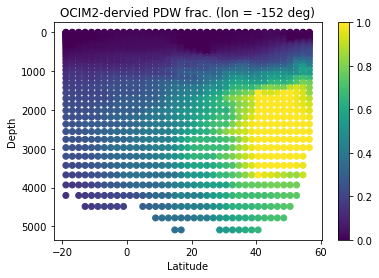

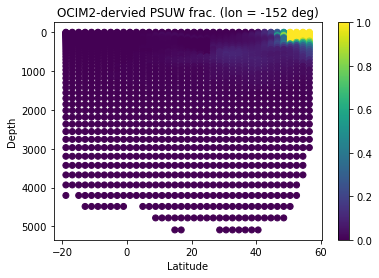

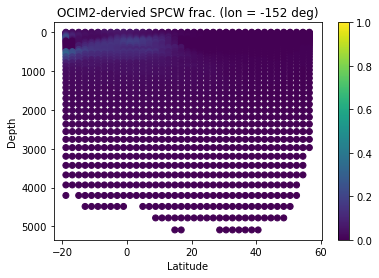

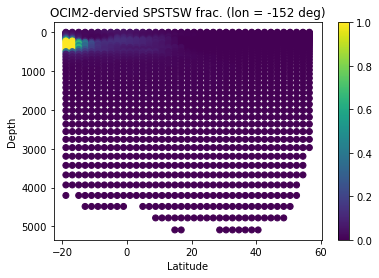

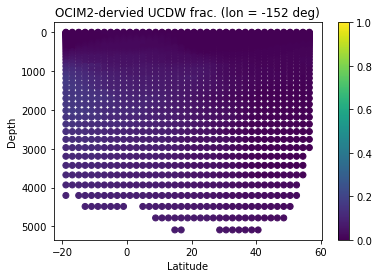

In [225]:
for endmem in endmem_to_lateststatevec:
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=endmem_to_lateststatevec[endmem][gp15_idxs],
        vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title("OCIM2-dervied "+endmem+" frac. (lon = -152 deg)")
    plt.colorbar()
    plt.show()

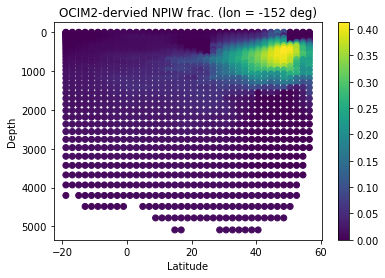

In [213]:
#with more timesteps